In [1]:
!pip3 install kaggle
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "content/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
  status, done = downloader.next_chunk()
  print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


!mkdir ~/.kaggle
!cp /content/content/kaggle.json ~/.kaggle/kaggle.json

!mkdir data
!kaggle competitions download -c retail-case-study-b7 -p data

Download 100%.
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘data’: File exists
WeatherData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
Train_Kaggle.csv: Skipping, found more recently modified local copy (use --force to force download)
Test_Kaggle.csv: Skipping, found more recently modified local copy (use --force to force download)
Sample_Submission.csv: Skipping, found more recently modified local copy (use --force to force download)
MacroEconomicData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
Events_HolidaysData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
AttributesDescription.xlsx: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!mkdir ../input/
!kaggle competitions download -c retail-case-study-b7 -p ../input/
!ls data

mkdir: cannot create directory ‘../input/’: File exists
WeatherData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
Train_Kaggle.csv: Skipping, found more recently modified local copy (use --force to force download)
Test_Kaggle.csv: Skipping, found more recently modified local copy (use --force to force download)
Sample_Submission.csv: Skipping, found more recently modified local copy (use --force to force download)
MacroEconomicData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
Events_HolidaysData.xlsx: Skipping, found more recently modified local copy (use --force to force download)
AttributesDescription.xlsx: Skipping, found more recently modified local copy (use --force to force download)
AttributesDescription.xlsx  Sample_Submission.csv  WeatherData.xlsx
Events_HolidaysData.xlsx    Test_Kaggle.csv
MacroEconomicData.xlsx	    Train_Kaggle.csv


In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline

import math, time, random, datetime

# Data Manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier


## Importing required packages
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
import os


# Lets ignore the warnings for now
import warnings
warnings.filterwarnings('ignore')

# for RNN
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("../input"))

trainPD = pd.read_csv('../input/Train_Kaggle.csv')
testPD  = pd.read_csv('../input/Test_Kaggle.csv')
sampleSubPD  = pd.read_csv('../input/Sample_Submission.csv')

attDescPD = pd.read_excel('../input/AttributesDescription.xlsx')
eventHolidaysPD = pd.read_excel('../input/Events_HolidaysData.xlsx')
macroEconomicsPD = pd.read_excel('../input/MacroEconomicData.xlsx')
weatherDataPD = pd.read_excel('../input/WeatherData.xlsx')

['Train_Kaggle.csv', 'Test_Kaggle.csv', 'Events_HolidaysData.xlsx', 'WeatherData.xlsx', 'Sample_Submission.csv', 'MacroEconomicData.xlsx', 'AttributesDescription.xlsx']


In [8]:
macroEconomicsPD.head()

,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
1,2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2,2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
3,2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
4,2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


In [6]:
macroEconomicsPD.keys()

Index(['Year-Month', 'Monthly Nominal GDP Index (inMillion$)',
       'Monthly Real GDP Index (inMillion$)', 'CPI', 'PartyInPower',
       'unemployment rate', 'CommercialBankInterestRateonCreditCardPlans',
       'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan',
       'Earnings or wages  in dollars per hour',
       'AdvertisingExpenses (in Thousand Dollars)',
       'Cotton Monthly Price - US cents per Pound(lbs)', 'Change(in%)',
       'Average upland planted(million acres)',
       'Average upland harvested(million acres)', 'yieldperharvested acre',
       'Production (in  480-lb netweright in million bales)',
       'Mill use  (in  480-lb netweright in million bales)', 'Exports'],
      dtype='object')

Text(0, 0.5, 'GDP')

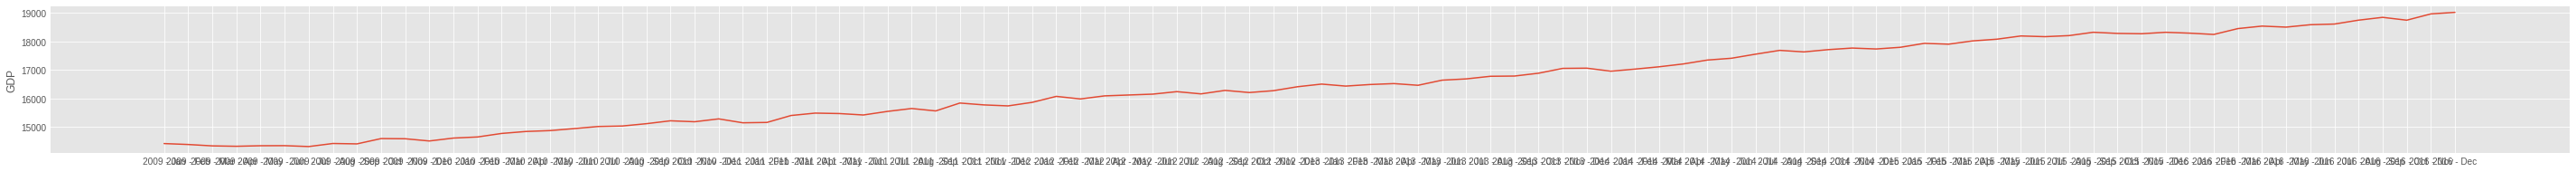

In [16]:
plt.rcParams["figure.figsize"] = (50,3)
plt.plot(macroEconomicsPD['Year-Month'], macroEconomicsPD['Monthly Nominal GDP Index (inMillion$)'])
# plt.style.use('ggplot')
# macroEconomicsPD[['Monthly Nominal GDP Index (inMillion$)', 'unemployment rate']].T.plot(kind='bar')
plt.ylabel('GDP')

Text(0, 0.5, 'Sales(In ThousandDollars)')

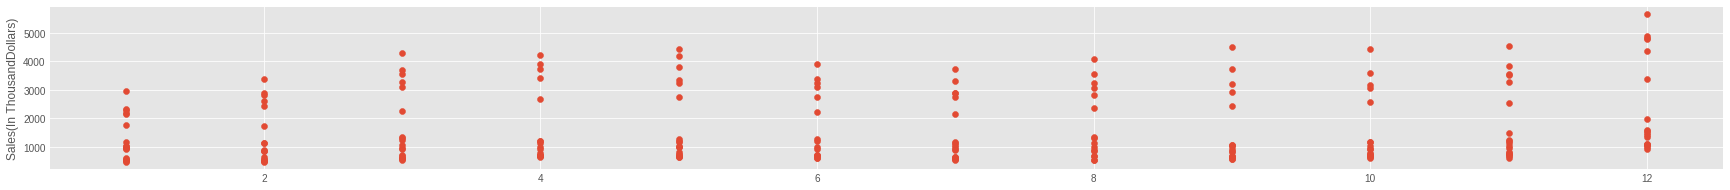

In [26]:
plt.rcParams["figure.figsize"] = (30,3)
plt.style.use('ggplot')
plt.scatter(trainPD['Month'], trainPD['Sales(In ThousandDollars)'])
plt.ylabel('Sales(In ThousandDollars)')

In [0]:
for index, row in macroEconomicsPD.iterrows():
  print(row['Monthly Real GDP Index (inMillion$)'])

In [36]:
macro_2009 = []
macro_2015 = []

for index, each in macroEconomicsPD.iterrows():
  if ('2009' in each['Year-Month']):
    print(each['Year-Month'])
    macro_2009.append(each['Monthly Real GDP Index (inMillion$)'])
    
print()
for index, each in macroEconomicsPD.iterrows():
  if ('2015' in each['Year-Month']):
    print(each['Year-Month'])
    macro_2015.append(each['Monthly Real GDP Index (inMillion$)'])

2009 - Jan
2009 - Feb
2009 - Mar
2009 - Apr
2009 - May
2009 - Jun
2009 - Jul
2009 - Aug
2009 - Sep
2009 - Oct
2009 - Nov
2009 - Dec

2015 - Jan
2015 - Feb
2015 - Mar
2015 - Apr
2015 - May
2015 - Jun
2015 - Jul
2015 - Aug
2015 - Sep
2015 - Oct
2015 - Nov
2015 - Dec


In [37]:
macro_2015

[16319.7863140255,
 16400.9267370766,
 16329.5237919176,
 16427.1366713661,
 16434.4823764629,
 16521.3018856824,
 16475.9998544967,
 16505.5376150738,
 16601.4898786932,
 16540.8597231567,
 16524.1994942689,
 16578.0045444115]

In [38]:
macro_2009

[14407.053343022,
 14366.1765714005,
 14351.7868217385,
 14351.6017305356,
 14368.1239591978,
 14346.8201055735,
 14345.6760973542,
 14435.812508554,
 14425.9727515716,
 14595.3930938759,
 14559.4101732519,
 14471.040843924]

In [42]:
month_wise_ratio = [macro_2015[i]/macro_2009[i] for i, each in enumerate(macro_2015)]
print(month_wise_ratio)

[1.1327636488505073, 1.1416347735643724, 1.137804232653696, 1.144620438875086, 1.1438154642271383, 1.1515654175704166, 1.1484993626431728, 1.1433743410904913, 1.1508055757893063, 1.1332931985296855, 1.1349497883249868, 1.1455986285445499]


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    
    data['ProductCategory'] = LabelEncoder().fit_transform(data['ProductCategory'])
    
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
    data_1=pd.get_dummies(data_1)
    if is_train==True:
        my_imputer = SimpleImputer()
        x = my_imputer.fit_transform(data_1)
        data_1 = pd.DataFrame({'Year':x[:,0],'Month':x[:,1], 'ProductCategory':x[:,2],'Sales(In ThousandDollars)':x[:,3]})
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1

X_train, X_val, y_train, y_val=processDataForModelling(trainPD,'Sales(In ThousandDollars)',drop_cols=[],is_train=True,split=0.2)

rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_val)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_val))
print("RMSE for Random Forest is ",rf_rmse)

Shape of Training Features (172, 3)
Shape of Validation Features  (44, 3)
RMSE for Random Forest is  272.8300492202536


In [44]:
len(rf_pred)

44

In [45]:
test_data=processDataForModelling(testPD,'Sales(In ThousandDollars)',drop_cols=['Sales(In ThousandDollars)'],is_train=False)
test_data.head()
rf_test_pred= rf.predict(test_data)
print(rf_test_pred)
print(len(rf_test_pred))

Shape of Test Data (36, 3)
[3183.62        590.93       1180.81470588 3440.21        610.7
 1233.14352941 4126.14        682.36       1286.18647059 4229.29
  778.08       1307.96117647 4323.21        788.14       1365.03352941
 4033.94        764.39764706 1529.24235294 3973.34        729.88764706
 1247.91529412 4230.54       1179.86647059 1269.65352941 4360.06
  778.40117647 1105.77352941 4349.86352941  762.94       1162.86352941
 4537.51        790.87       1345.32       5229.49       1072.35
 1760.92      ]
36


In [51]:
# rf_test_pred
rf_test_pred_WithRatio = []
for index, each in enumerate(month_wise_ratio):
  for i in [0, 1, 2]:
    rf_test_pred_WithRatio.append(rf_test_pred[index*3 + i] * month_wise_ratio[index] )
  
  
print(rf_test_pred_WithRatio)

[3606.289007753452, 669.3840230152302, 1337.5839748516328, 3927.4633643638895, 697.1963562157623, 1407.7995339723714, 4694.739556521721, 776.392096193576, 1463.4284102172128, 4840.931775930013, 890.606271079927, 1497.1190958433392, 4944.954453101406, 901.4867199759768, 1561.3464601297278, 4645.345800554007, 880.2538956251381, 1761.0226087310743, 4563.378457564624, 838.2754974481838, 1433.2299199267854, 4837.090884956967, 1349.0290483835881, 1451.6892676043933, 5017.581358775923, 895.7884140833087, 1272.5303432072792, 4929.670752414686, 864.6347128862383, 1317.865328700578, 5149.846014022512, 897.5977390925823, 1526.870649229371, 5990.896571987438, 1228.482689319748, 2017.3075369766689]


In [0]:
rf_test_pred_WithRatio = [int(round(each)) for each in rf_test_pred_WithRatio]

In [53]:
print(rf_test_pred_WithRatio)

[3606, 669, 1338, 3927, 697, 1408, 4695, 776, 1463, 4841, 891, 1497, 4945, 901, 1561, 4645, 880, 1761, 4563, 838, 1433, 4837, 1349, 1452, 5018, 896, 1273, 4930, 865, 1318, 5150, 898, 1527, 5991, 1228, 2017]


In [54]:

# create a submission dataframe and append the relevant columns
submission = pd.DataFrame()
submission['Year'] = testPD['Year']
submission['Sales(In ThousandDollars)'] = rf_test_pred_WithRatio
submission.head()

# check if submission and test dateframe are of same length
if len(submission) == len(testPD):
    print('Submission dataframe is the same length as test ({} rows)'.format(len(submission)))
else:
    print("Dataframe mismatched, won't be able to submit to Kaggle.")
    
    
# make a csv file for the submission
submission.to_csv('dtRegWithGDP.csv', index = False)
print('Submission is ready')

Submission dataframe is the same length as test (36 rows)
Submission is ready


In [62]:
macroEconomicsPD.head()

,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports
0,2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550
1,2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100
2,2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650
3,2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225
4,2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300


In [59]:
macroEconomicsPD.dtypes

Year-Month                                                            object
Monthly Nominal GDP Index (inMillion$)                               float64
Monthly Real GDP Index (inMillion$)                                  float64
CPI                                                                  float64
PartyInPower                                                          object
unemployment rate                                                    float64
CommercialBankInterestRateonCreditCardPlans                          float64
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan    float64
Earnings or wages  in dollars per hour                               float64
AdvertisingExpenses (in Thousand Dollars)                             object
Cotton Monthly Price - US cents per Pound(lbs)                       float64
Change(in%)                                                          float64
Average upland planted(million acres)                                float64

In [0]:
macroEconomicsPD_temp = macroEconomicsPD
year = []
month = []
for index, each in macroEconomicsPD_temp.iterrows():
#   if ('2009' in each['Year-Month']):
  year.append(each['Year-Month'][:5])
#   else:
#     year.append('Not required')
    
  month_value = each['Year-Month'][-3:]
  month.append(month_value)
    
macroEconomicsPD_temp['Year'] = year
macroEconomicsPD_temp['Month'] = month



In [106]:
macroEconomicsPD_temp.dtypes


Year-Month                                                            object
Monthly Nominal GDP Index (inMillion$)                               float64
Monthly Real GDP Index (inMillion$)                                  float64
CPI                                                                  float64
PartyInPower                                                          object
unemployment rate                                                    float64
CommercialBankInterestRateonCreditCardPlans                          float64
Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan    float64
Earnings or wages  in dollars per hour                               float64
AdvertisingExpenses (in Thousand Dollars)                             object
Cotton Monthly Price - US cents per Pound(lbs)                       float64
Change(in%)                                                          float64
Average upland planted(million acres)                                float64

In [117]:
macroEconomicsPD_temp.head(15)

,Year-Month,Monthly Nominal GDP Index (inMillion$),Monthly Real GDP Index (inMillion$),CPI,PartyInPower,unemployment rate,CommercialBankInterestRateonCreditCardPlans,"Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan",Earnings or wages in dollars per hour,AdvertisingExpenses (in Thousand Dollars),Cotton Monthly Price - US cents per Pound(lbs),Change(in%),Average upland planted(million acres),Average upland harvested(million acres),yieldperharvested acre,Production (in 480-lb netweright in million bales),Mill use (in 480-lb netweright in million bales),Exports,Year,Month
0,2009 - Jan,14421.752895,14407.053343,233.402,Democrats,7.8,12.03,11.44,22.05,137,57.70,4.02,9.296,7.559,799,12.589,4.17,11.550,2009,Jan
1,2009 - Feb,14389.200466,14366.176571,234.663,Democrats,8.3,12.97,11.05,22.22,200,55.21,-4.32,9.296,7.559,799,12.589,3.87,11.100,2009,Feb
2,2009 - Mar,14340.701639,14351.786822,235.067,Democrats,8.7,12.97,11.05,22.22,?,51.50,-6.72,9.296,7.559,799,12.589,3.72,11.650,2009,Mar
3,2009 - Apr,14326.815525,14351.601731,235.582,Democrats,9.0,12.97,11.05,22.13,214,56.78,10.25,9.296,7.559,787,12.400,3.62,12.225,2009,Apr
4,2009 - May,14345.904809,14368.123959,235.975,Democrats,9.4,13.32,11.25,22.04,?,61.95,9.11,9.297,7.400,803,12.384,3.52,12.300,2009,May
5,2009 - Jun,14348.530666,14346.820106,237.172,Democrats,9.5,13.32,11.25,21.96,?,61.39,-0.90,8.668,7.760,796,12.876,3.47,10.300,2009,Jun
6,2009 - Jul,14317.372922,14345.676097,237.600,Democrats,9.5,13.32,11.25,22.00,?,64.80,5.55,8.905,7.753,796,12.863,3.47,9.700,2009,Jul
7,2009 - Aug,14424.284901,14435.812509,238.282,Democrats,9.6,13.71,10.89,22.16,?,64.26,-0.83,8.905,7.619,809,12.840,3.47,9.700,2009,Aug
8,2009 - Sep,14410.777177,14425.972752,238.568,Democrats,9.8,13.71,10.89,22.20,?,64.07,-0.30,8.989,7.582,827,13.071,3.47,10.000,2009,Sep
9,2009 - Oct,14596.605447,14595.393094,238.380,Democrats,10.0,13.71,10.89,22.27,?,66.82,4.29,8.989,7.586,799,12.631,3.37,10.000,2009,Oct


In [92]:
weatherDataPD.dtypes

Year                           object
Month                          object
Day                             int64
Temp high (°C)                  int64
Temp avg (°C)                   int64
Temp low (°C)                   int64
Dew Point high (°C)             int64
Dew Point avg (°C)              int64
Dew Point low (°C)              int64
Humidity (%) high               int64
Humidity (%) avg                int64
Humidity (%) low                int64
Sea Level Press. (hPa) high     int64
Sea Level Press. (hPa) avg      int64
Sea Level Press. (hPa) low      int64
Visibility (km) high            int64
Visibility (km) avg             int64
Visibility (km) low             int64
Wind (km/h) low                object
Wind (km/h) avg                object
Wind (km/h) high               object
Precip. (mm) sum               object
WeatherEvent                   object
dtype: object

In [61]:
weatherDataPD.head()

,Year,Month,Day,Temp high (°C),Temp avg (°C),Temp low (°C),Dew Point high (°C),Dew Point avg (°C),Dew Point low (°C),Humidity (%) high,Humidity (%) avg,Humidity (%) low,Sea Level Press. (hPa) high,Sea Level Press. (hPa) avg,Sea Level Press. (hPa) low,Visibility (km) high,Visibility (km) avg,Visibility (km) low,Wind (km/h) low,Wind (km/h) avg,Wind (km/h) high,Precip. (mm) sum,WeatherEvent
0,2009,Jan,1,-3,-6,-9,-16,-17,-19,54,43,32,1025,1023,1015,16,16,16,37,18,60,0,NaN
1,2009,Jan,2,1,-2,-5,-3,-7,-17,78,57,36,1022,1012,1007,16,13,2,27,10,48,T,Snow
2,2009,Jan,3,3,1,-2,-5,-9,-13,72,54,35,1018,1015,1008,16,16,16,27,16,42,T,NaN
3,2009,Jan,4,6,1,-4,-10,-12,-13,55,42,29,1020,1017,1015,16,16,16,32,12,40,0,NaN
4,2009,Jan,5,6,5,3,-1,-5,-16,62,48,33,1016,1014,1013,16,16,16,23,11,34,T,NaN


In [0]:
data_w1 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2009', ignore_index=True)
data_w2 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2010', ignore_index=True)
data_w3 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2011', ignore_index=True)
data_w4 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2012', ignore_index=True)
data_w5 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2013', index_col=None)
data_w6 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2014', index_col=None)
data_w7 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2015', index_col=None)
data_w8 = pd.read_excel('../input/WeatherData.xlsx', sheet_name='2016', index_col=None)

data_w1['Year'] = data_w1['Year'].astype('str') 
data_w2.Year='2010'
data_w3.Year='2011'
data_w4.Year='2012'
data_w5.Year='2013'
data_w6.Year='2014'
data_w7.Year='2015'
data_w8.Year='2016'
cdf=data_w1
cdf = cdf.append(data_w2)
cdf = cdf.append(data_w3)
cdf = cdf.append(data_w4)
cdf = cdf.append(data_w5)
cdf = cdf.append(data_w6)
cdf = cdf.append(data_w7)
cdf = cdf.append(data_w8)
# cdf.dropna()
weatherDataPD_temp = cdf

In [0]:
weatherDataPD_temp

In [132]:
weatherDataPD_temp['Month'].value_counts()

Jul    248
Jan    248
May    248
Aug    248
Mar    248
Dec    248
Oct    248
Sep    240
Nov    240
Jun    240
Apr    240
Feb    226
nan      1
Name: Month, dtype: int64

In [125]:
# weatherDataPD_temp = weatherDataPD
weatherDataPD_temp['Year'] = weatherDataPD_temp['Year'].apply(str)
weatherDataPD_temp['Month'] = weatherDataPD_temp['Month'].apply(str)
weatherDataPD_temp.dtypes

Year                            object
Month                           object
Day                            float64
Temp high (°C)                  object
Temp avg (°C)                   object
Temp low (°C)                   object
Dew Point high (°C)             object
Dew Point avg (°C)              object
Dew Point low (°C)              object
Humidity (%) high               object
Humidity (%) avg                object
Humidity (%) low                object
Sea Level Press. (hPa) high     object
Sea Level Press. (hPa) avg      object
Sea Level Press. (hPa) low      object
Visibility (km) high            object
Visibility (km) avg             object
Visibility (km) low             object
Wind (km/h) low                 object
Wind (km/h) avg                 object
Wind (km/h) high                object
Precip. (mm) sum                object
WeatherEvent                    object
dtype: object

In [101]:
print(len(weatherDataPD_temp))
print(len(macroEconomicsPD_temp))

2923
96


In [111]:
weatherDataPD_temp_grouped = weatherDataPD_temp.groupby(['Year','Month'], as_index=False).agg(lambda x : x.mean() if x.dtype=='int64' else x.head(1))
print(len(weatherDataPD_temp_grouped))



97


In [130]:
weatherDataPD_temp_grouped['Year'].value_counts()

2014    13
2010    12
2012    12
2011    12
2013    12
2015    12
2009    12
2016    12
Name: Year, dtype: int64

In [129]:
weatherDataPD_temp_grouped.dtypes

Year                            object
Month                           object
Day                            float64
Temp high (°C)                  object
Temp avg (°C)                   object
Temp low (°C)                   object
Dew Point high (°C)             object
Dew Point avg (°C)              object
Dew Point low (°C)              object
Humidity (%) high               object
Humidity (%) avg                object
Humidity (%) low                object
Sea Level Press. (hPa) high     object
Sea Level Press. (hPa) avg      object
Sea Level Press. (hPa) low      object
Visibility (km) high            object
Visibility (km) avg             object
Visibility (km) low             object
Wind (km/h) low                 object
Wind (km/h) avg                 object
Wind (km/h) high                object
Precip. (mm) sum                object
WeatherEvent                    object
dtype: object

In [0]:
merge_weather_economic1 = pd.merge(weatherDataPD_temp_grouped, macroEconomicsPD_temp, on=['Year', 'Month'])

In [134]:
merge_weather_economic1.shape

(0, 41)

In [0]:
# merge_weather_economic = pd.merge(weatherDataPD_temp, macroEconomicsPD_temp, on=['Year', 'Month'])

In [123]:
# merge_weather_economic.shape

(0, 41)

In [0]:
# merge_weather_economic=merge_weather_economic.groupby(['Year','Month'], as_index=False).agg(lambda x : x.mean() if x.dtype=='int64' else x.head(1))

In [0]:
# merge_weather_economic

In [0]:
merge_weather_economic = merge_weather_economic.drop(['AdvertisingExpenses (in Thousand Dollars)', 'Day', 'PartyInPower','Year-Month', 'WeatherEvent'], axis = 1)


In [85]:
print(merge_weather_economic)

    Year Month  ...  Mill use  (in  480-lb netweright in million bales)  Exports
0   2009   Apr  ...                                               3.62    12.225
1   2009   Aug  ...                                               3.47     9.700
2   2009   Dec  ...                                               3.37    10.425
3   2009   Feb  ...                                               3.87    11.100
4   2009   Jan  ...                                               4.17    11.550
5   2009   Jul  ...                                               3.47     9.700
6   2009   Jun  ...                                               3.47    10.300
7   2009   Mar  ...                                               3.72    11.650
8   2009   May  ...                                               3.52    12.300
9   2009   Nov  ...                                               3.37     9.950
10  2009   Oct  ...                                               3.37    10.000
11  2009   Sep  ...         